## Testing Grounds


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import cupy as cp
import visual 

%matplotlib inline
plt.style.use('dark_background')


In [2]:

test_dir = r'C:\Users\Callisto\Documents\edhirata\tutorials\M25_napari\notebooks\test_data'
test_crop = os.path.join(test_dir,'dustball2_crop.jpeg')
main_img = os.path.join(test_dir,'dustball2.jpeg')


In [3]:
#Template matching needs uint8 or float32 files
template = cv.imread(test_crop,0).astype(np.float32)
img = cv.imread(main_img,0).astype(np.float32)

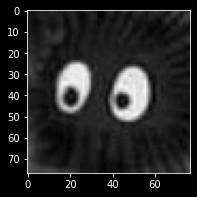

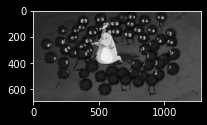

In [4]:
plt.figure(figsize=(3,3))
plt.imshow(template,cmap='gray')
plt.figure(figsize=(3,3))
plt.imshow(img,cmap='gray')


## Taking Opencv tempalte matching example

In [5]:
w,h = template.shape
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']


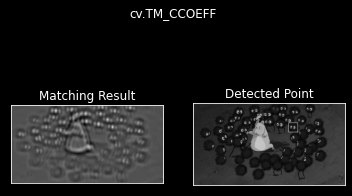

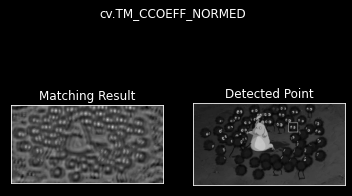

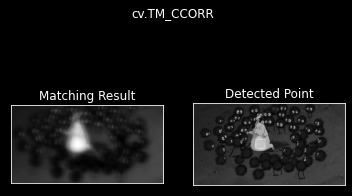

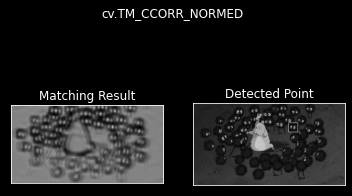

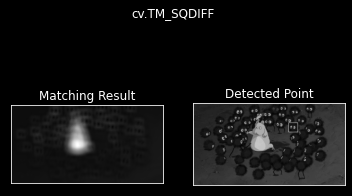

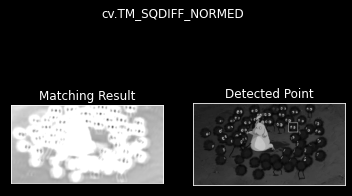

In [6]:
for meth in methods:
    img2 = img.copy()
    method = eval(meth) # This method parses expression and runs ()
    
    # Apply template Matching
    # Slide through image and compare template patches.
    # Comparison of best matches is foudn as global minn in SQDIFF or max in CCORR or CCOEF.
    res = cv.matchTemplate(img2,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img2,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [7]:
import napari
viewer=napari.Viewer()
viewer.add_image(img)

<Image layer 'img' at 0x21d3dbc9220>

In [8]:
## https://forum.image.sc/t/mask-and-crop-with-napari/54008/2

def create_box(data):
    """Create integer box

    Parameters
    ----------
    data : (N, 2) array
        Points around which the box is created.

    Returns
    -------
    box : (2, 2) array
        Integrer extrema of the box.
    """
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    tl = np.array([min_val[0], min_val[1]])
    br = np.array([max_val[0], max_val[1]])
    box = np.round(np.array([tl, br])).astype(int)
    return box

def crop(image, rectangle):
    """Create integer box

    Parameters
    ----------
    image : (N, M) array
        2D image.
    rectangle : (4, 2) array or (2, 2) array
        Rectangle for cropping.

    Returns
    -------
    cropped_image : (U, V) array
        Cropped 2D image.
    """
    min_val, max_val = create_box(rectangle)
    return image[min_val[0]: max_val[0], min_val[1]: max_val[1]]



In [9]:
crop_region = np.array([[154.48405703, 693.79029786],
       [154.48405703, 758.35170378],
       [210.24163487, 758.35170378],
       [210.24163487, 693.79029786]])

In [11]:
# crop_region =viewer.layers['Shapes'].data[0]
cropped_img = crop(img,crop_region)
viewer.add_image(cropped_img)


<Image layer 'cropped_img' at 0x21d0398c4c0>

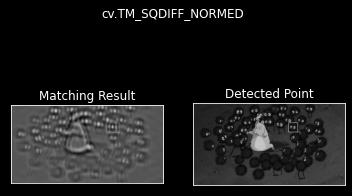

In [12]:
    method = eval(methods[0]) # This method parses expression and runs ()
    # Apply template Matching
    # Slide through image and compare template patches.
    # Comparison of best matches is foudn as global minn in SQDIFF or max in CCORR or CCOEF.
    res = cv.matchTemplate(img2,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img2,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [13]:
from cupyx.scipy.ndimage import shift
import cupy as cp
import random 

random.seed(1)

shift_stack_coord =[(random.randrange(-100,100),random.randrange(-100,100)) for i in range(25)] 
shift_stack_coord[12] =(0,0)
# shift_stack_coord =[[0,0],[100,200], [150,-150],[-50,100],[-20,-50]]
img_stack = []

for i in range(len(shift_stack_coord)):
    img_stack.append(img)
img_stack=np.array(img_stack)

img_stack.shape



(25, 690, 1280)

In [14]:
# Generate our own shifted datset
with cp.cuda.Device(0):
    stack = []
    for i in range(len(shift_stack_coord)):
        cp_stack = cp.array(img_stack[i])
        shift_stack_cam= shift(cp_stack,shift_stack_coord[i])
        stack.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    stack = np.array(stack)

In [15]:
visual.image_stack_viewer(stack, size=(5,5))

interactive(children=(IntSlider(value=0, description='stack_idx', max=24), Output()), _dom_classes=('widget-in…

<function visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [16]:
viewer.add_image(stack)

<Image layer 'stack' at 0x21d0bc73550>

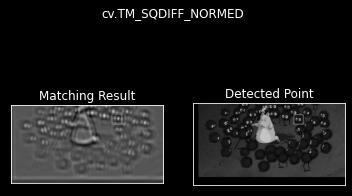

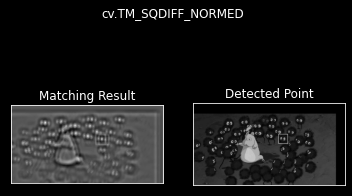

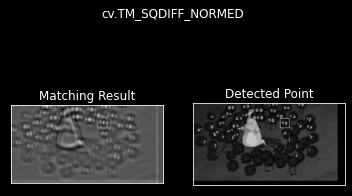

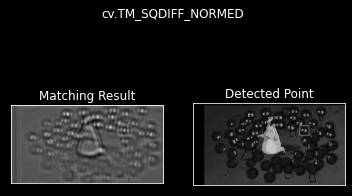

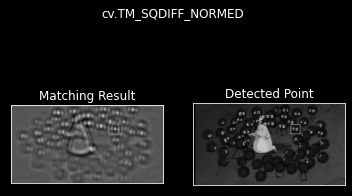

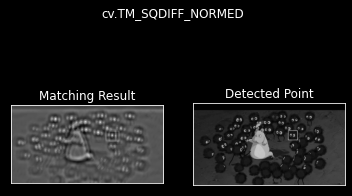

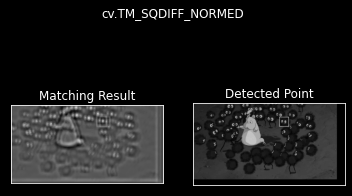

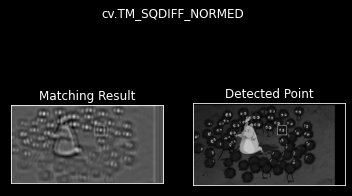

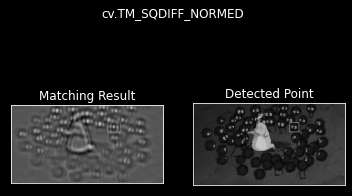

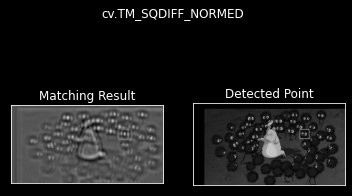

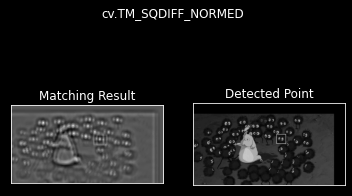

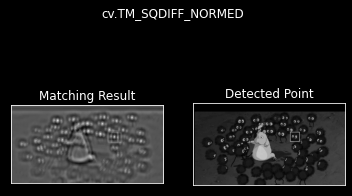

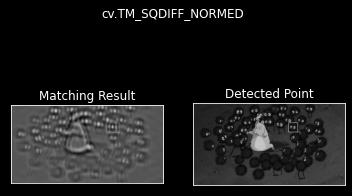

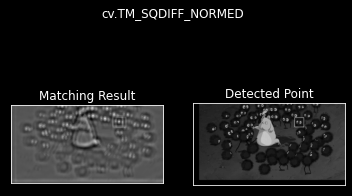

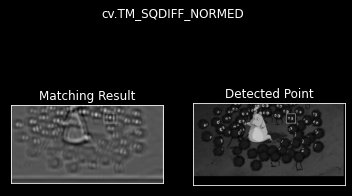

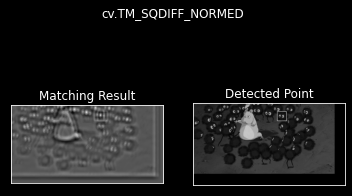

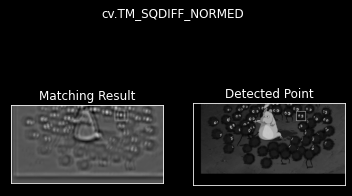

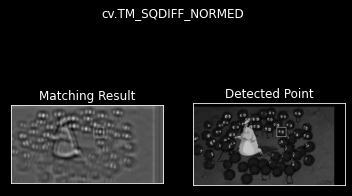

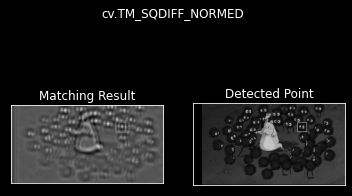

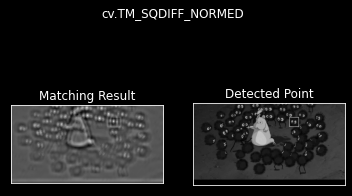

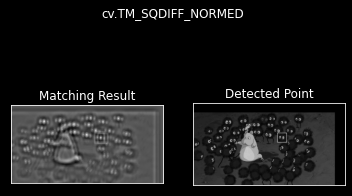

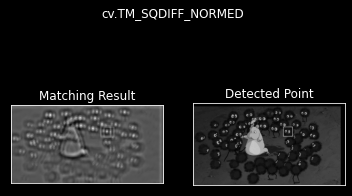

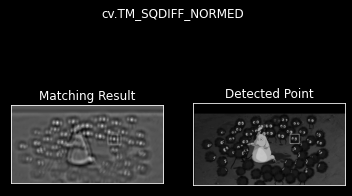

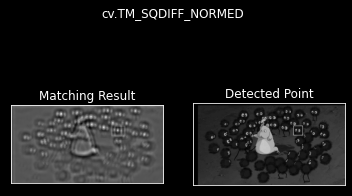

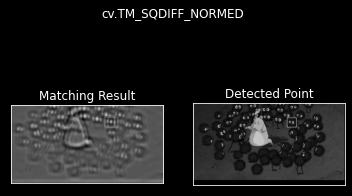

In [41]:
w,h = template.shape

coord= []

for i in range(stack.shape[0]):
    method = eval(methods[0]) # This method parses expression and runs ()
    # Apply template Matching
    # Slide through image and compare template patches.
    # Comparison of best matches is foudn as global minn in SQDIFF or max in CCORR or CCOEF.
    res = cv.matchTemplate(stack[i],template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    coord.append(((top_left[1],top_left[0]),(bottom_right[1],bottom_right[0])))
#     print(top_left)
    cv.rectangle(stack[i],top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(stack[i],cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [48]:
shift_stack_coord

[(-66, 45),
 (95, -84),
 (-35, -70),
 (26, 94),
 (15, 20),
 (66, -3),
 (-47, -76),
 (24, -93),
 (-1, 10),
 (55, 95),
 (96, -100),
 (78, 14),
 (0, 0),
 (-42, 51),
 (-74, -19),
 (-93, -95),
 (-94, 66),
 (38, -98),
 (-3, 75),
 (-45, 8),
 (85, -93),
 (35, -44),
 (95, 12),
 (26, 41),
 (-41, -12)]

In [47]:
t = np.array(coord[0])
print(t)
t.shape

[[106 844]
 [183 921]]


(2, 2)

In [37]:
shapes_layer =viewer.add_shapes()


In [45]:
shapes_layer.add(t,shape_type=['rectangle'],edge_width=3,edge_color='yellow',face_color='transparent')

In [19]:
res = []
diff =[]

for i,coordinate in enumerate(coord):
    val = tuple(map(lambda i, j: i - j, coord[0],coordinate))
    res.append(val)
    diff.append(tuple(map(lambda i, j: i + j, val,shift_stack_coord[i])))

    
print(diff)
print(res)
print(shift_stack_coord)



[(-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45), (-66, 45)]
[(0, 0), (-161, 129), (-31, 115), (-92, -49), (-81, 25), (-132, 48), (-19, 121), (-90, 138), (-65, 35), (-121, -50), (-162, 145), (-144, 31), (-66, 45), (-24, -6), (8, 64), (27, 140), (28, -21), (-104, 143), (-63, -30), (-21, 37), (-151, 138), (-101, 89), (-161, 33), (-92, 4), (-25, 57)]
[(-66, 45), (95, -84), (-35, -70), (26, 94), (15, 20), (66, -3), (-47, -76), (24, -93), (-1, 10), (55, 95), (96, -100), (78, 14), (0, 0), (-42, 51), (-74, -19), (-93, -95), (-94, 66), (38, -98), (-3, 75), (-45, 8), (85, -93), (35, -44), (95, 12), (26, 41), (-41, -12)]


In [20]:
# Generate our own shifted datset
with cp.cuda.Device(0):
    stack_aligned = []
    for i in range(len(shift_stack_coord)):
        cp_stack = cp.array(stack[i])
        shift_stack_cam= shift(cp_stack,res[i])
        stack_aligned.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    stack_aligned = np.array(stack_aligned)

In [21]:
visual.image_stack_viewer(stack_aligned, size=(5,5))

interactive(children=(IntSlider(value=0, description='stack_idx', max=24), Output()), _dom_classes=('widget-in…

<function visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [22]:
viewer.add_image(stack_aligned)

<Image layer 'stack_aligned' at 0x21d03a4a940>